Training the model

In [3]:
import csv
import cv2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sklearn
import random
import json

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D
from keras.layers import Cropping2D, SpatialDropout2D, Dropout
%matplotlib inline

import os
import shutil

batch_size = 400
epoch = 10

folder = '../data/'
cameras = ['left', 'center', 'right']
steering_adj = {'left': 0.25, 'center': 0., 'right': -.25}

thresh_prob = 0.2

def crop_image(img, c_height=66, c_width=200):
        '''
        crop image
        '''
        image_array = img[60:135, :]
        cropped = cv2.resize(image_array, (200, 66),interpolation=cv2.INTER_AREA)
        return cropped

def image_translation(image, steering):
    
    # Translation
    rows, cols, _ = image.shape
    trans_range = 100
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steering = steering + tr_x/trans_range*2*.2
#     tr_y = 40*np.random.uniform()-40/2
    tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    return image, steering

def select_row(train):
    """
    select row according to the steering value, low value has low probability
    """
    keep_prob = 0
    while keep_prob == 0:
        row = train.iloc[np.random.randint(len(train))]
        y = row['steering']
        if (y <= 0.1):
            if random.random() <= thresh_prob:
                keep_prob = 1
        else:
            keep_rob = 1
    return row

def select_camera_image(row):
    """
    select camera uniformly
    """
    cameras = ['left', 'center', 'right']
    steering = float(row['steering'])
    # use one of the cameras randomily
    camera = random.choice(cameras)
    steering += steering_adj[camera]
    image = plt.imread(folder+row[camera].strip())
    return image, steering

def train_generator(train):
    """
    training data generator
    """
    while(1):
            images = []
            steerings = []
            while(len(images) < batch_size): 
                
                    row = select_row(train)
                    image, steering = select_camera_image(row)
                    image, steering = image_translation(image, steering)
                    
                    # flip 50% randomily that are not driving straight
                    if random.random() >= .5:
                        image = np.fliplr(image)
                        steering = -steering
                        
                    image = crop_image(image)
                    images.append(image)
                    steerings.append(steering)

            yield np.array(images),np.array(steerings)

def valid_generator(valid):

    camera = 'center'
    while True:  # need to keep generating data

        # initialise data extract
        images = []
        steerings = []
        
        # create a random batch to return
        while len(images) < batch_size:

            row = valid.iloc[np.random.randint(len(valid))]
            #no need to adjust, we only used the center camera
            steering = row['steering']
            image = plt.imread(folder+row[camera].strip())
            image = crop_image(image)

            images.append(image)
            steerings.append(steering)

        # yield the batch
        yield np.array(images), np.array(steerings)

def build_model():
        # row, column, channel = 160, 320, 3
        # shape = (row, column, channel)
        """
        Model based on Nvidia paper
        http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
        """
        height, width = 66, 200
        dropout = 0.25
        activation_relu = 'elu'
        
        model = Sequential()
        model.add(Lambda(lambda x:x/127.5 - 1.0, input_shape=(height,width,3)))
        #convlution
        model.add(Convolution2D(24,5,5, subsample=(2,2), activation=activation_relu))
        model.add(SpatialDropout2D(dropout))
        model.add(Convolution2D(36,5,5, subsample=(2,2), activation=activation_relu))
        model.add(SpatialDropout2D(dropout))
        model.add(Convolution2D(48,5,5, subsample=(2,2), activation=activation_relu))
        model.add(SpatialDropout2D(dropout))
        model.add(Convolution2D(64,3,3, activation=activation_relu))
        model.add(SpatialDropout2D(dropout))
        model.add(Convolution2D(64,3,3, activation=activation_relu))
        model.add(SpatialDropout2D(dropout))
        
        #fully connected
        model.add(Flatten())
        model.add(Dropout(dropout))
        model.add(Dense(100, activation=activation_relu))
#         model.add(Dropout(dropout))
        model.add(Dense(50,activation=activation_relu))
#         model.add(Dropout(dropout))
        model.add(Dense(10,activation=activation_relu))
        model.add(Dropout(dropout))
        model.add(Dense(1))

        model.compile(loss='mse',optimizer='adam')
        return model


In [4]:
    
    num_training = 5000
    num_valid  = 2000
    weightfile = 'weights1/'
    modelfile = 'models1/'
    shutil.rmtree(weightfile, ignore_errors=True)
    shutil.rmtree(modelfile, ignore_errors=True)
    os.makedirs(weightfile,exist_ok=True)
    os.makedirs(modelfile,exist_ok=True)
    
    thresh_origin = 1.0
    
    loss = []
    val_loss = []
    
    for i in range(5):
    
        path = folder+'driving_log.csv'
        data = pd.read_csv(path, index_col=False)
        data.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
        
        # Shuffle data
        data_shuffle = data.iloc[np.random.permutation(data.index)].reset_index(drop=True)
        # Split data on a multiple of BATCH SIZE
        split = int(len(data_shuffle) * 0.9)
        train_data = data_shuffle[:split]
    
        val_data = data_shuffle[split:]

        model = build_model()
        model.summary()
        model.compile("adam", "mse")
        samples_per_epoch = num_training

        values = model.fit_generator(train_generator(train_data), samples_per_epoch=samples_per_epoch, nb_epoch=epoch, \
                                     validation_data=valid_generator(val_data), nb_val_samples=len(val_data))

        model_rep = model.to_json()

    #save model to avoid retraining from begining all the time
        json_string = model.to_json()
        with open(modelfile+'model'+str(i)+'.json', 'w') as outfile:
            json.dump(json_string, outfile)

        model.save(weightfile+'model'+str(i)+'.h5')
        
        print('\nmodel_epoch_'+str(i)+' saved')
#         thresh_prob = thresh_origin/(1+i)
        print('threshold probability is: ', thresh_prob)
#     print(history_object.history.keys())
        loss.append(values.history['loss'][-1])
        val_loss.append(values.history['val_loss'][-1])


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 66, 200, 3)    0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_2[0][0]                   
____________________________________________________________________________________________________
spatialdropout2d_6 (SpatialDropo (None, 31, 98, 24)    0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 14, 47, 36)    21636       spatialdropout2d_6[0][0]         
___________________________________________________________________________________________

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


5200/5000 [===============================] - 25s - loss: 0.1544 - val_loss: 0.0197
Epoch 2/10
5200/5000 [===============================] - 21s - loss: 0.0697 - val_loss: 0.0192
Epoch 3/10
5200/5000 [===========

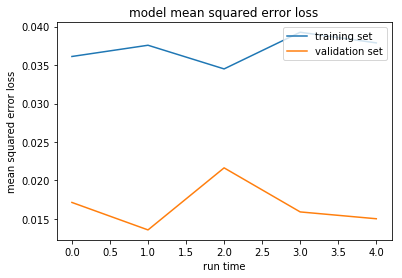

In [5]:
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('run time')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.savefig('loss.png')
    plt.show(block=True)